# Comparing computational efficiency of methods

In [1]:
%revisions -s -n 10

Previously I've ran this specific DSC using:

```
dsc susie.dsc --target run_comparison -o susie_comparison
```

Which focuses on simulated PVE = 0.2.

So here I query from that result for computational time. Notice that for each susie and DAP run the two replicates were not performed in parallel (because they are relatively fast hence the lack of need) so benchmark time of susie and dap have to be divided by 2.

Also there is some overhead of DAP, CAVIAR and FINEMAP in converting results format to command line acceptable formats. So the benchmark is a bit more favorable to susie. However we run susie unoptimized in terms of computational efficiency and some trivial optimization will boost susie's speed. So let's just ignore all these minor caveats now. The more significant chunk of computation is in the actual finemapping algorithm.

Here we focus on 3 causal signal scenario.

In [2]:
[global]
cwd = path('~/GIT/github/mvarbvs/dsc')
dirname = path(f'{cwd:a}/susie_comparison/')
date = '1008'
susie_prior = 0.1
null_weight = 0.0
def fmtP(x):
    return str(x).replace(".", "p")

## Get data

In [3]:
[speed_1]
output: f'{dirname}/speed_comparison_{date}.rds'
R: expand = '${ }', workdir = cwd
    dap_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less.n_signal fit_dap")
    susie_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less.n_signal fit_susie fit_susie.prior_var fit_susie.null_weight")
    caviar_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less.n_signal fit_caviar fit_caviar.args")
    finemap_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less.n_signal fit_finemap fit_finemap.args")
    saveRDS(list(dap=dap_out, susie=susie_out, caviar=caviar_out, finemap=finemap_out), ${_output:r})

## Speed comparison

In [4]:
[speed_2]
# CAVIAR and FINEMAP runs were paralleled for performance. Need to factor it in
paralleled = 2
output: f'{_input:n}_prior_{fmtP(susie_prior)}_null_{fmtP(null_weight)}.rds'
R: stdout = f'{_output:n}.log', expand = '${ }', workdir = cwd
    dat = readRDS(${_input:r})
    dap_out = dat$dap
    caviar_out = dat$caviar
    susie_out = dat$susie
    finemap_out = dat$finemap
    # favorite susie flavor
    susie_out = susie_out[which(susie_out$fit_susie.prior_var == ${susie_prior} & susie_out$fit_susie.null_weight == ${null_weight}), ]
    susie_out = subset(susie_out, select =-c(fit_susie.prior_var, fit_susie.null_weight))

    data_sets = unique(susie_out$liter_data.dataset)
    res = matrix(0, length(data_sets), 4)
    colnames(res) = c('SuSiE', 'DAP', 'FINEMAP', 'CAVIAR')
    s = 3
    i = 0
    for (d in data_sets) {
        i = i + 1
        out_files = susie_out[which(susie_out$lm_less.n_signal == s & susie_out$liter_data.dataset == d),c("fit_susie.output.file"),drop=FALSE]
        res[i,1] = dscrutils::read_dsc(paste0(${dirname:r}, '/', out_files[1,1]))$DSC_DEBUG$time$elapsed / ${paralleled}
        out_files = dap_out[which(dap_out$lm_less.n_signal == s & dap_out$liter_data.dataset == d),c("fit_dap.output.file"),drop=FALSE]
        res[i,2] = dscrutils::read_dsc(paste0(${dirname:r}, '/', out_files[1,1]))$DSC_DEBUG$time / ${paralleled}
        out_files = finemap_out[which(finemap_out$lm_less.n_signal == s & finemap_out$liter_data.dataset == d & finemap_out$fit_finemap.args == paste('--n-causal-max', s)),c("fit_finemap.output.file"),drop=FALSE]
        res[i,3] = dscrutils::read_dsc(paste0(${dirname:r}, '/', out_files[1,1]))$DSC_DEBUG$time$elapsed
        out_files = caviar_out[which(caviar_out$lm_less.n_signal == s & caviar_out$liter_data.dataset == d & caviar_out$fit_caviar.args == paste('-g 0.001 -c', s)),c("fit_caviar.output.file"),drop=FALSE]
        res[i,4] = dscrutils::read_dsc(paste0(${dirname:r}, '/', out_files[1,1]))$DSC_DEBUG$time$elapsed
    }
    saveRDS(res, ${_output:r})

In [ ]:
[speed_3]
input: group_by = 1, concurrent = True
output: f'{_input:n}.png'
R: expand = '${ }'
    dat = readRDS(${_input:r})
    library(reshape2)
    dat = melt(data = dat, measure.vars = colnames(dat))
    colnames(dat) = c('id', 'method', 'time')
    library(ggplot2)
    library(cowplot)
    # Basic violin plot
    png(${_output:r}, 600, 600)
    p = ggplot(dat, aes(x=method, y=time)) + 
      geom_violin(trim=FALSE, fill="gray")+
      labs(title="",x="method", y = "time elapsed (seconds)")+
      geom_boxplot(width=0.1)+
      theme_cowplot()
    print(p)
    dev.off()

In [2]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

## susie estimate residual variance

In [21]:
dat = readRDS('susie_comparison/speed_comparison_0630_estvar_true.rds')

In [24]:
t(apply(dat, 2, function(x) c(mean(x), min(x), max(x))))

susie,2.97561,0.925000,7.26000
dap,12.44603,9.781471,24.97176
finemap,99.01583,52.553000,179.71600
caviar,3398.43827,3364.481000,3434.94400


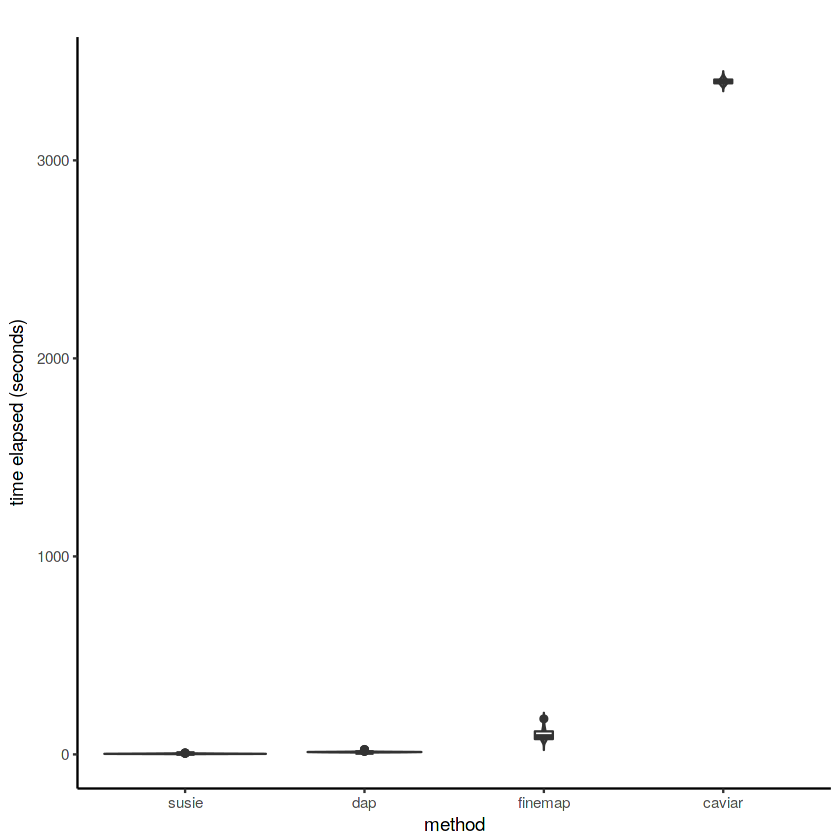

In [18]:
%preview susie_comparison/speed_comparison_0630_estvar_true.png

In [ ]:
%preview 